In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML
np.random.seed(42)

import seaborn as sns
sns.set_style("white")
matplotlib.rcParams['figure.figsize'] = [20, 15]


## A Primer on Linear Regression
Linear regression will be a tool we use to assess our readout.
Let's first talk a bit about what the pieces of a linear regression mean: slope, intercept, $r^2$, mean-square error, etc.


In [2]:
x = np.random.uniform(-10,10,1000)


def noise_exercise(x,m0=0.0,m1=0.0,m2=1.0,m3=0,n1=0,n2=2,samps=1000):
    m = np.array([m0,m1,m2,m3]).T
    x = x[:samps]
    y = np.dot(m,np.array([x**3,x**2,x,1])) + np.random.normal(n1,n2,size=x.shape)
    x_real = np.linspace(-10,10,10)
    y_real = np.dot(m,np.array([x_real**3,x_real**2,x_real,1]))

    x = x.reshape(-1,1)
    y = y.reshape(-1,1)

    plt.scatter(x,y)
    plt.plot(x_real,y_real,color='red')
    plt.xlim((-10,10))
    plt.ylim((-20,20))

    # calculate our stats for the regression
    r_model = LinearRegression()
    r_model.fit(x,y)
    y_pred = r_model.predict(x)

    pred_line = r_model.coef_ * x_real + r_model.intercept_
    plt.plot(x_real,pred_line.T,color='green')
    
    rmse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)

    plt.text(11,10,'R2 ' + str(r2))
    plt.text(11,5,'Slope ' + str(r_model.coef_))
    plt.text(11,0,'Intercept ' + str(r_model.intercept_))

noise_widg = interactive(noise_exercise,x=fixed(x),m0=(-1.0,1.0,0.1),m1=(-1.0,1.0,0.1),m2=(-1.0,1.0,0.1),m3=(0.0,10.0,0.1),n1=(0.0,5.0,0.1),n2=(0.0,20.0,1.0),samps=(2,100,1))
display(noise_widg)

interactive(children=(FloatSlider(value=0.0, description='m0', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

Try this:
    Set the m0 to 0.0
    Set the m1 to 0.3 -> This makes the true relationship an $x^2$ relationship.
    Set m2 at 1.0
    Set the noise n2 at something high first, then something low
    Finally, set the samples to something around 50
    
Tweak around with it but what you'll see is that you linear regression line has a poor $r^2$ fit score.

This is expected because, well, you're trying to fit an $x^2$ relationship with an $x^1$ model. This is a fundamental model mismatch.

Now try setting the M0 to 1.0
You'll see the $r^2$ improve.
This is because an $x^3$ is better fit by a linear model since it doesn't "turn around" in negative numbers.

If we moved this up to $x^4$ the $r^2$ would get bad again. Try it!

## Predicted vs Actual
Now that we're familiar with the basics of linear regression, let's get to the focus: we're trying to predict something.



In [3]:
def pva(noise1=1,h1=0,h4=0):
    t = np.linspace(0,10,1000)
    x = []
    for ii in range(5):
        x.append(np.sin(2 * np.pi * np.random.uniform(0,10) * t) + np.random.normal(0,noise1,size=t.shape))

    x = np.array(x)
    gamma = np.array([0,1,1,1,0])
    h = np.array([h1,1,1,h4,0])

    y = np.dot(h,x)
    beta = np.dot(gamma,x)

    y = y.reshape(-1,1)
    beta = beta.reshape(-1,1)
    r_model = LinearRegression()
    r_model.fit(beta,y)
    y_pred = r_model.predict(beta)
    r2 = r2_score(beta,y)
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(y)
    plt.plot(beta)
    plt.subplot(2,1,2)
    plt.scatter(beta,y)
    plt.plot([-15,15],[-15,15],linestyle='dotted')
    plt.xlim((-15,15))
    plt.ylim((-15,15))
    plt.text(16,10,'R2 ' + str(r2))
    plt.text(16,5,'Slope ' + str(r_model.coef_))
    plt.text(16,0,'Intercept ' + str(r_model.intercept_))

    
readout_widg = interactive(pva,noise1=(0,10,1),h1=(0,5,1),h4=(0,1,1))
display(readout_widg)

interactive(children=(IntSlider(value=1, description='noise1', max=10), IntSlider(value=0, description='h1', m…

## Networked regions
Finally we're going to look at a 'more realistic' set of brain regions, regions that communicate with each other.


interactive(children=(IntSlider(value=1, description='noise1', max=10), IntSlider(value=0, description='h1', m…

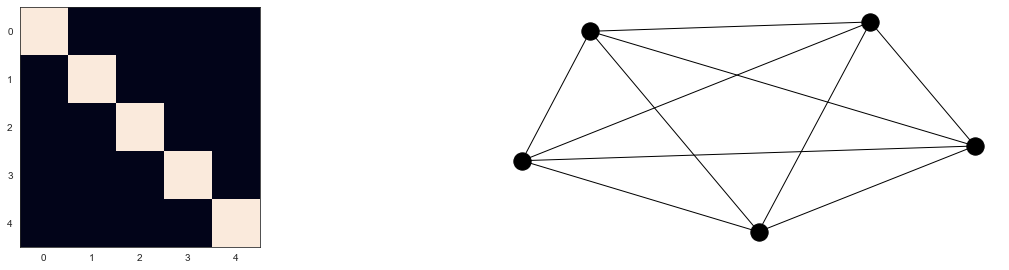

In [4]:
import networkx as nx

def pva_net(noise1=1,h1=0,h4=0):
    n_nodes = 5
    t = np.linspace(0,10,1000)
    x = []
    for ii in range(n_nodes):
        x.append(np.sin(2 * np.pi * np.random.uniform(0,10) * t) + np.random.normal(0,noise1,size=t.shape))
    x = np.array(x)
    
    network_G = nx.erdos_renyi_graph(n_nodes,0.8)
    covar = nx.laplacian_matrix(network_G).todense()
    corr_noise = np.random.multivariate_normal(mean=np.zeros((n_nodes,)), cov=covar,size=1000).T
    x += corr_noise
    
    gamma = np.array([1,1,1,1,0])
    h = np.array([h1,1,1,h4,0])

    y = np.dot(h,x)
    beta = np.dot(gamma,x)

    y = y.reshape(-1,1)
    beta = beta.reshape(-1,1)
    r_model = LinearRegression()
    r_model.fit(beta,y)
    y_pred = r_model.predict(beta)
    r2 = r2_score(beta,y)
    
    print(np.where(gamma != 0))
    
    plt.figure()
    plt.subplot(3,2,1)
    plt.imshow(covar)
    plt.subplot(3,2,2)
    pos = nx.spring_layout(network_G)
    nx.draw(network_G,pos=pos,node_color='black') #all nodes
    dz_nodes = nx.draw_networkx_nodes(network_G,pos=pos,nodelist=np.where(gamma != 0)[0],node_color='none',linewidths=8.0)# just the nodes related to disease
    dz_nodes.set_edgecolor('blue')
    nx.draw_networkx_nodes(network_G,pos=pos,nodelist=np.where(h != 0)[0],node_color='green') #the nodes that are measured
    
    plt.subplot(3,1,2)
    plt.plot(y)
    plt.plot(beta)
    plt.subplot(3,1,3)
    plt.scatter(beta,y)
    plt.plot([-15,15],[-15,15],linestyle='dotted')
    plt.xlim((-15,15))
    plt.ylim((-15,15))
    plt.text(16,10,'R2 ' + str(r2))
    plt.text(16,5,'Slope ' + str(r_model.coef_))
    plt.text(16,0,'Intercept ' + str(r_model.intercept_))

    
readout_widg = interactive(pva_net,noise1=(0,10,1),h1=(0,5,1),h4=(0,1,1))
display(readout_widg)